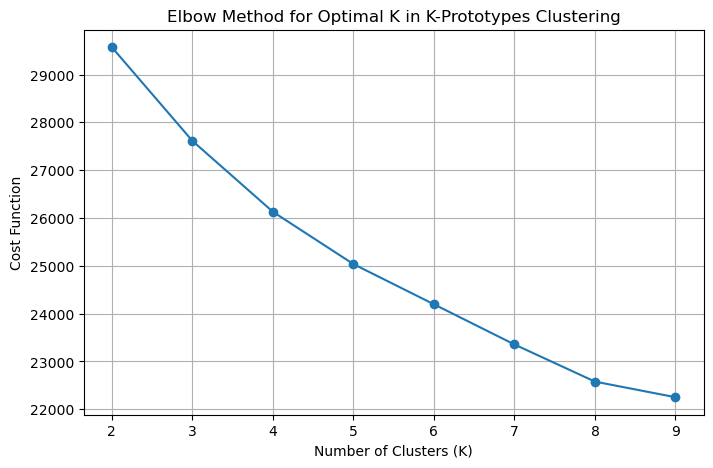

In [12]:
import warnings
warnings.filterwarnings('ignore')

from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
file_path = "shopping_behavior_updated.csv"
df = pd.read_csv(file_path)

# Use all available features
df_full = df.copy()
df_full.drop(['Customer ID'], axis=1, inplace=True)

# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

# Encode categorical variables
label_encoders = {}
scalers = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_full[col] = le.fit_transform(df_full[col])
    label_encoders[col] = le

for col in numerical_cols:
    scaler = StandardScaler()
    df_full[col] = scaler.fit_transform(df_full[[col]])
    scalers[col] = scaler

# Convert dataframe to numpy array for KPrototypes
df_full_np = df_full.to_numpy()

# Determine the optimal number of clusters using the elbow method
costs = []
K_range = range(2, 10)
for k in K_range:
    kp = KPrototypes(n_clusters=k, init="Cao", n_init=5, verbose=0)
    clusters = kp.fit_predict(df_full_np, categorical=[df_full.columns.get_loc(col) 
                                                       for col in categorical_cols])    
    costs.append(kp.cost_)

# Plot the cost function to find the optimal K
plt.figure(figsize=(8, 5))
plt.plot(K_range, costs, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Cost Function")
plt.title("Elbow Method for Optimal K in K-Prototypes Clustering")
plt.grid(True)
plt.show()



In [31]:
# Apply K-Prototypes clustering with optimal K (assume 4 for now, replace based on the plot)
optimal_k = 4
kprototypes_model = KPrototypes(n_clusters=optimal_k, init="Cao", n_init=5, verbose=0)
df_full["prod_cluster"] = kprototypes_model.fit_predict(df_full_np, categorical=[df_full.columns.get_loc(col) for col in categorical_cols])

# Decode cluster composition back to human-readable values
def decode_cluster(row):
    for col in categorical_cols:
        # print( label_encoders[col].inverse_transform([int(row[col])])[0])
        row[col] = label_encoders[col].inverse_transform([int(row[col])])[0]
    
    return row

for col in numerical_cols:
    df_full[col] = scalers[col].inverse_transform(df_full[[col]])

cluster_composition = df_full.groupby("prod_cluster").apply(lambda x: x.mode().iloc[0]).apply(decode_cluster, axis=1)

# Investigate clustering results
cluster_counts = df_full["prod_cluster"].value_counts()
cluster_summary = df_full.groupby("prod_cluster").mean()


In [33]:
cluster_composition.T

prod_cluster,0,1,2,3
0,,,,
Age,59.0,57.0,25.0,27.0
Gender,Male,Male,Male,Male
Item Purchased,Jacket,Jewelry,Blouse,Pants
Category,Clothing,Clothing,Clothing,Clothing
Purchase Amount (USD),83.0,33.0,90.0,28.0
Location,Illinois,Maryland,North Dakota,Montana
Size,M,M,M,M
Color,Violet,Silver,Green,Black
Season,Spring,Fall,Winter,Summer


1. Gender is not useful. I think it's because most of customers are male in this shopping mall.
2. Cluster 0, 1, 3, 4 are interesting. The mode for `Gender` is male, but mode for `Item Purchased` are items for women.
3. Cluster 0 and 4 are top spender. But they are distinctively different in many interesting ways.
4. We need to watch for cluster 3. Their `Review Rating` is pretty low.

In [34]:
import seaborn as sns

<Axes: xlabel='prod_cluster', ylabel='count'>

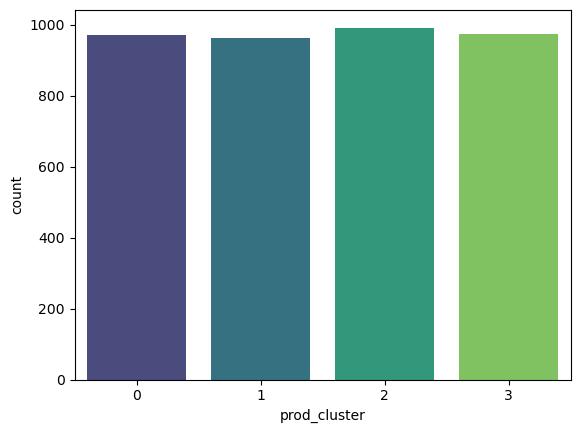

In [35]:
sns.barplot(cluster_counts, palette='viridis')

They are evenly distributed.

In [37]:
cluster_counts

prod_cluster
2    992
3    974
0    971
1    963
Name: count, dtype: int64

In [ ]:
df_full[df_full["prod_cluster"] == 0]

# Silhouette Score

In [65]:
from sklearn.metrics import silhouette_score

In [67]:
kprototypes_per_k = [KPrototypes(n_clusters=k, n_init=20, random_state=1)\
                     .fit(df_full_np, categorical=[df_full.columns.get_loc(col) 
                                                       for col in categorical_cols])
                for k in range(1, 10)]

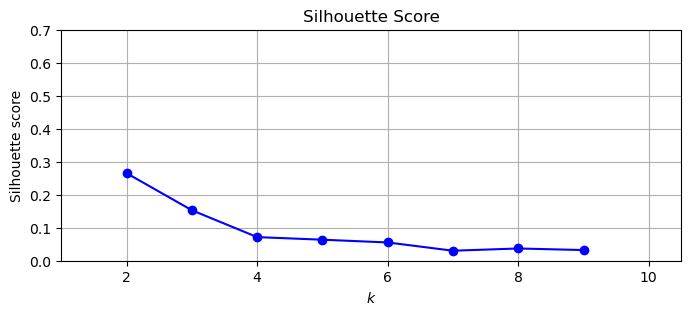

In [73]:
silhouette_scores = [silhouette_score(df_full, model.labels_)
                     for model in kprototypes_per_k[1:]] # can't calculate for k=1

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.axis([1, 10.5, 0, 0.7])
plt.grid()
plt.title("Silhouette Score")
plt.show()

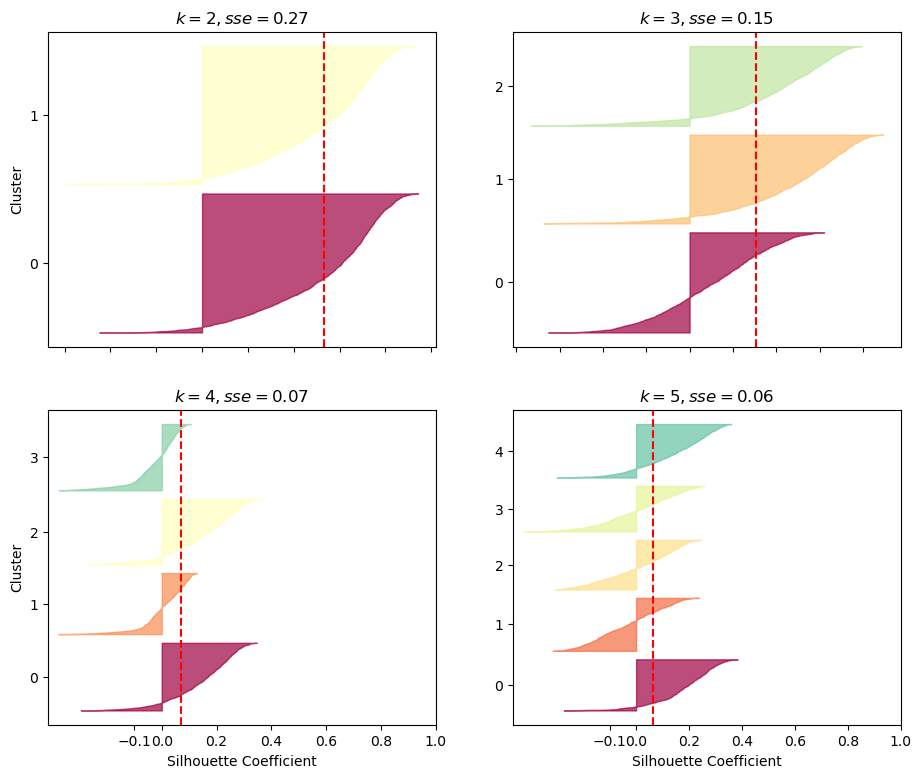

In [75]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kprototypes_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(df_full, y_pred)

    padding = len(df_full_np) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 4):
        plt.ylabel("Cluster")
    
    if k in (4, 5):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k-2], color="red", linestyle="--")
    plt.title(f"$k={k},sse={silhouette_scores[k-2].round(2)}$")
plt.show()

In [166]:
from kmodes.kmodes import KModes
from kmodes import kprototypes
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np

kproto = KPrototypes(n_clusters=5, init='Huang', random_state=42)
labels = kproto.fit_predict(df_full_np, categorical=categorical_indices)

# Compute silhouette score (custom mixed distance function)
def mixed_distance(a, b, categorical_indices):
    """ Computes the mixed Euclidean and Hamming distance """
    num_distance = np.linalg.norm(a[:-len(categorical_indices)] - b[:-len(categorical_indices)])
    cat_distance = sum(a[categorical_indices] != b[categorical_indices])
    return num_distance + cat_distance  # Weighted sum can be adjusted

In [167]:
dist_matrix = cdist(df_full_np, df_full_np, metric=lambda u, v: mixed_distance(u, v, categorical_indices))

In [168]:
silhouette_score(dist_matrix, labels, metric='precomputed')

-0.01231890623066555

In [148]:
df.drop(['Customer ID'], axis=1, inplace=True)
categorical_indices = []
for col in categorical_cols:
    categorical_indices.append(df.columns.get_loc(col))

In [130]:
categorical_indices

[2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]

In [158]:
len(dist_matrix)

3900